In [1]:
from tqdm.notebook import tqdm
from functools import partial

import jax
from jax import numpy as jnp
import numpy as np
import haiku as hk
import optax

from dart import dataset, VirtualRadar, fields

In [2]:
sensor = VirtualRadar.from_config("data/sim_96.json", n=256, k=128)

gt = dataset.gt_map("data/map.mat")
ds = dataset.image_traj("data/traj.mat", "data/sim_96.npz")
ds = ds.shuffle(10000, reshuffle_each_iteration=True).batch(32)

In [3]:
def forward(poses):
    key = hk.next_rng_key()
    keys = jax.random.split(key, poses.v.shape[0])
    sigma = fields.SimpleGrid(
        gt.grid.shape, lower=gt.lower, resolution=gt.resolution)
    return jax.vmap(partial(sensor.render, sigma=sigma))(keys, pose=poses)

dart = hk.transform(forward)

data_trace = jax.tree_util.tree_map(jnp.array, list(ds.take(1))[0][0])
params = dart.init(jax.random.PRNGKey(42), data_trace)
key = jax.random.PRNGKey(42)

optimizer = optax.adamw(optax.exponential_decay(
    0.01, 500, 0.01, transition_begin=100, end_value=0.001))
opt_state = optimizer.init(params)

def step(rng, pose, y_true, params, opt_state):

    def loss_func(params):
        y_pred = dart.apply(params, rng, pose)
        return jnp.sum((y_true - y_pred)**2) / y_pred.shape[0]
        # return jnp.mean((y_true - y_pred)**2)
    
    loss, grads = jax.value_and_grad(loss_func)(params)
    loss_clip = jax.tree_util.tree_map(jnp.nan_to_num, grads)
    updates, opt_state = optimizer.update(loss_clip, opt_state, params)
    params = optax.apply_updates(params, updates)
    params = jax.tree_util.tree_map(
        partial(jnp.clip, a_min=0.0, a_max=1.0), params)

    return params, opt_state, loss

for epoch in range(1):
    with tqdm(ds, unit="batch", desc="Epoch {}".format(epoch)) as _epoch:
        avg = 0
        for i, batch in enumerate(_epoch):
            key, rng = jax.random.split(key, 2)
            pose, y_true = jax.tree_util.tree_map(jnp.array, batch)
            params, opt_state, loss = jax.jit(step)(
                rng, pose, y_true, params, opt_state)

            avg = (avg * i + loss) / (i + 1)
            _epoch.set_postfix(loss=avg)

Epoch 0:   0%|          | 0/313 [00:00<?, ?batch/s]

2022-12-11 21:31:13.843876: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  dynamic-slice.18 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2022-12-11 21:31:14.204901: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 1.361107721s
Constant folding an instruction is taking > 1s:

  dynamic-slice.18 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

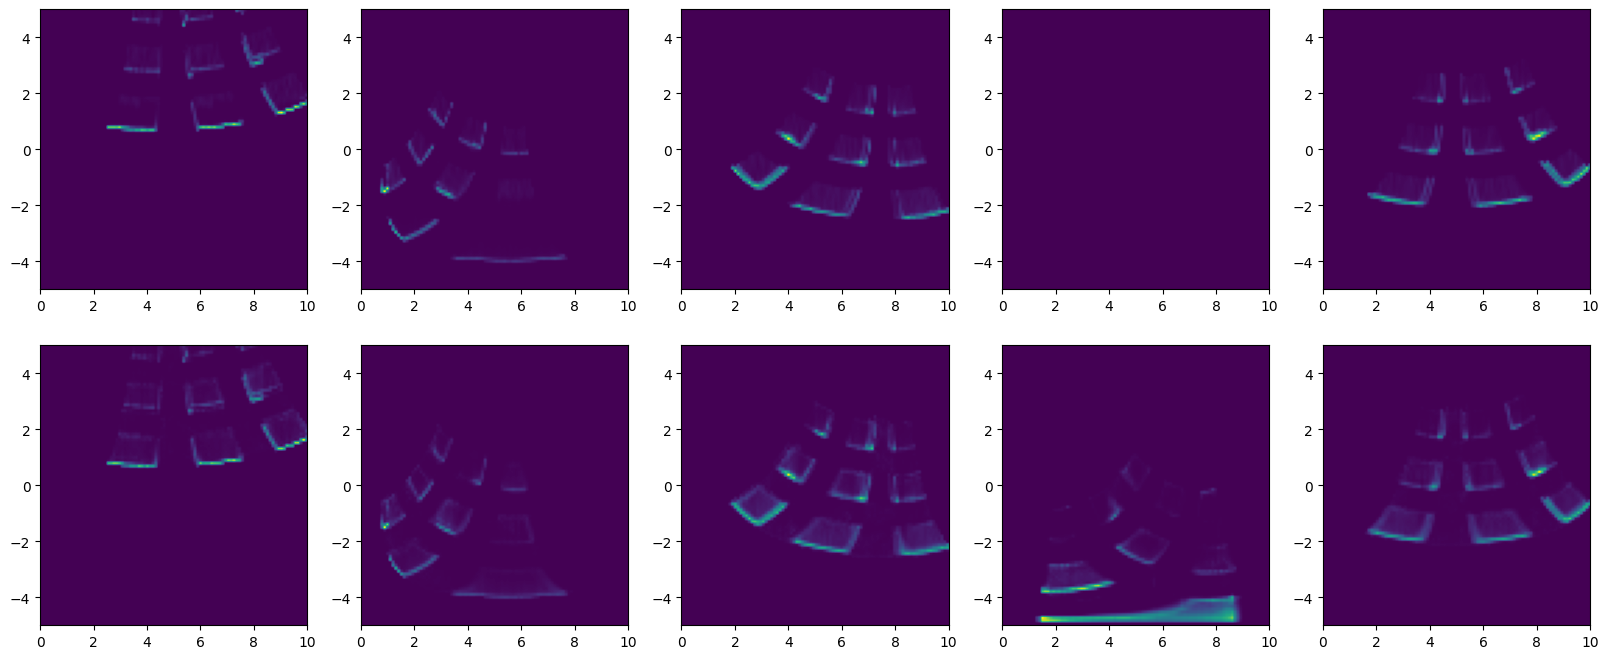

In [6]:
from matplotlib import pyplot as plt
import json

batch = jax.tree_util.tree_map(jnp.array, list(ds.take(1))[0])
pose, y_true = batch

fig, axs = plt.subplots(2, 5, figsize=(20, 8))


with open('data/sim_96.json') as f:
    cfg = json.load(f)

extents = [min(cfg['r']), max(cfg['r']), min(cfg['d']), max(cfg['d'])]

y_pred = dart.apply(params, jax.random.PRNGKey(42), pose)
for y1, y2, col in zip(y_true, y_pred, axs.T):
    col[0].imshow(y1, extent=extents, aspect='auto', origin='lower')
    col[1].imshow(y2, extent=extents, aspect='auto', origin='lower')

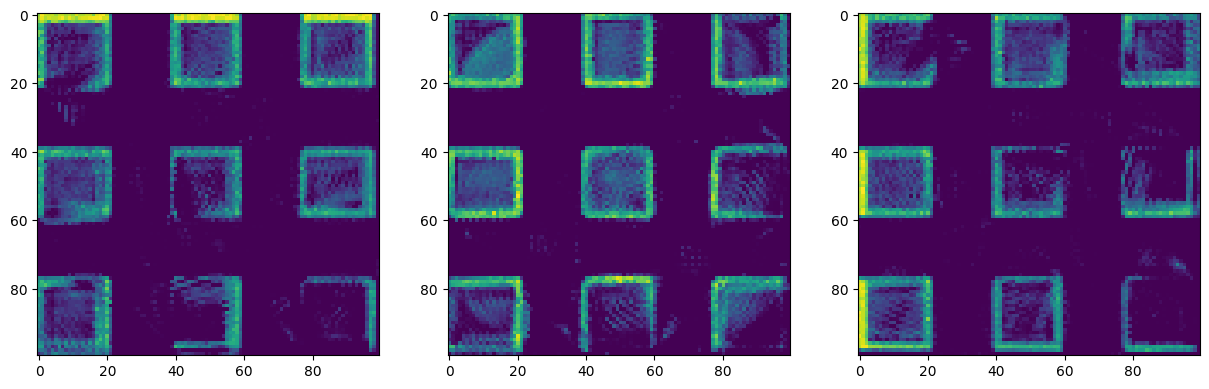

In [7]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for layer, ax in zip([10, 50, 90], axs):
    ax.imshow(params['simple_grid']['grid'][:, :, layer])